<a href="https://colab.research.google.com/github/JuanD4vy/SDN_Project/blob/main/NTL_SDN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***Universidad Militar Nueva Granada***
**Juan David Aviles Palma**

**Programa de ingeniería en Telecomunicaciones - Semillero Maxwell GISSIC**

**El presente archivo de Colab corresponde a la primera prueba del entreamiento del modelo Random Forest para la clasificación de tráfico malicioso del tráfico normal**

#***0. Importar librerías y cargar conjuntos de datos***

In [ ]:
# Conectar con Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importación de librerías
import time
import numpy as np
import random
import pandas as pd
import ipaddress
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Semilla para reproducibilidad
np.random.seed(0)
random.seed(0)

In [ ]:
# Cargar datasets
attack_train = pd.read_csv('/content/drive/MyDrive/Ataque/NTLFlowLyzer/Ataque_N.csv')
attack_test = pd.read_csv('/content/drive/MyDrive/Ataque/NTLFlowLyzer/Ataque_PN.csv')
normal_train = pd.read_csv('/content/drive/MyDrive/Normal/NTLFlowLyzer/Normal_N.csv')
normal_test = pd.read_csv('/content/drive/MyDrive/Normal/NTLFlowLyzer/Normal_PN.csv')

<ipython-input-4-f7d001a05b68>:4: DtypeWarning: Columns (237,238) have mixed types. Specify dtype option on import or set low_memory=False.
  normal_train = pd.read_csv('/content/drive/MyDrive/Normal/NTLFlowLyzer/Normal_N.csv')
<ipython-input-4-f7d001a05b68>:5: DtypeWarning: Columns (237,238) have mixed types. Specify dtype option on import or set low_memory=False.
  normal_test = pd.read_csv('/content/drive/MyDrive/Normal/NTLFlowLyzer/Normal_PN.csv')


#***1. Exploración y preprocesamiento de datos***

In [ ]:
# Muestra el tamaño del dataset de flujo normal
print("Dimensiones del dataset de flujo normal (Entrenamiento):", normal_train.shape)
print("Dimensiones del dataset de flujo normal (Prueba):", normal_test.shape)

Dimensiones del dataset de flujo normal (Entrenamiento): (257746, 347)
Dimensiones del dataset de flujo normal (Prueba): (122867, 347)


In [ ]:
# Muestra el tamaño del dataset de flujo de ataque
print("Dimensiones del dataset de flujo de ataque (Entrenamiento):", attack_train.shape)
print("Dimensiones del dataset de flujo de ataque (Prueba):", attack_test.shape)

Dimensiones del dataset de flujo de ataque (Entrenamiento): (259606, 347)
Dimensiones del dataset de flujo de ataque (Prueba): (73605, 347)


In [ ]:
# Identificar columnas con valores nulos y reemplazarlos con la media
def replace_missing_values(dataset, name):
    dataset.replace([np.inf, -np.inf], np.nan, inplace=True)  # Reemplazar valores infinitos por NaN

    # Intentar convertir columnas a numéricas si es posible
    for col in dataset.columns:
        dataset[col] = pd.to_numeric(dataset[col], errors='coerce')

    missing_values = dataset.isnull().sum()
    missing_values = missing_values[missing_values > 0]

    print(f"Columnas con valores nulos en {name}:", missing_values)

    # Rellenar con la media de cada columna
    dataset.fillna(dataset.mean(numeric_only=True), inplace=True)

    print(f"Valores nulos en {name} después del reemplazo: {dataset.isnull().sum().sum()}")

for dataset, name in zip([attack_train, attack_test, normal_train, normal_test],
                          ['train_attack', 'test_attack', 'train_normal', 'test_normal']):
    replace_missing_values(dataset, name)

Columnas con valores nulos en train_attack: flow_id                                 259606
timestamp                               259606
src_ip                                  259606
dst_ip                                  259606
protocol                                259606
payload_bytes_skewness                   40366
payload_bytes_cov                        40365
fwd_payload_bytes_skewness               31786
fwd_payload_bytes_cov                    27776
bwd_payload_bytes_skewness               54608
bwd_payload_bytes_cov                    54601
skewness_header_bytes                    58450
fwd_skewness_header_bytes                52652
bwd_skewness_header_bytes                41100
fwd_segment_size_skewness                29770
bwd_segment_size_skewness                27868
segment_size_skewness                    35743
active_skewness                           1974
idle_skewness                             1842
packets_IAT_skewness                     26118
fwd_packets_IAT_

**A continuación, se combinan los 2 datasets.**

In [ ]:
# Combinar y mezclar datos
train_dataset = pd.concat([attack_train, normal_train], ignore_index=True)
train_dataset = shuffle(train_dataset, random_state=42)
test_dataset = pd.concat([attack_test, normal_test], ignore_index=True)
test_dataset = shuffle(test_dataset, random_state=42)

In [ ]:
# Verificar valores nulos y eliminar columnas con datos nulos
cols_before = set(train_dataset.columns)
train_dataset.dropna(axis=1, inplace=True)
test_dataset.dropna(axis=1, inplace=True)
cols_after = set(train_dataset.columns)
eliminated_cols = cols_before - cols_after
print("Columnas eliminadas por contener valores nulos:", eliminated_cols)

Columnas eliminadas por contener valores nulos: {'timestamp', 'flow_id', 'src_ip', 'protocol', 'dst_ip'}


In [ ]:
# Convertir direcciones IP a valores numéricos si existen
for col in ['src_ip', 'dst_ip']:
    if col in train_dataset.columns:
        train_dataset[col] = train_dataset[col].apply(lambda ip: int(ipaddress.ip_address(ip)))
        test_dataset[col] = test_dataset[col].apply(lambda ip: int(ipaddress.ip_address(ip)))

In [ ]:
# Asegurar que solo haya datos numéricos
train_dataset = train_dataset.select_dtypes(include=['number'])
test_dataset = test_dataset.select_dtypes(include=['number'])

In [ ]:
train_dataset.head(10)  # Observar 10 primeras filas del dataset

,src_port,dst_port,duration,packets_count,fwd_packets_count,bwd_packets_count,total_payload_bytes,fwd_total_payload_bytes,bwd_total_payload_bytes,payload_bytes_max,...,min_fwd_payload_bytes_delta_len,max_fwd_payload_bytes_delta_len,mean_fwd_payload_bytes_delta_len,mode_fwd_payload_bytes_delta_len,variance_fwd_payload_bytes_delta_len,std_fwd_payload_bytes_delta_len,median_fwd_payload_bytes_delta_len,skewness_fwd_payload_bytes_delta_len,cov_fwd_payload_bytes_delta_len,label
228766,51268,80,191.613189,56,36,20,2831,2349,482,482,...,-275.0,168.0,0.00,0.0,5159.6000,71.8304,0.0,-1.0598,6.180156,1
9261,46852,80,0.000000,1,1,0,0,0,0,0,...,0.0,0.0,0.00,0.0,0.0000,0.0000,0.0,0.0000,0.000000,1
435124,43536,80,0.000000,1,1,0,0,0,0,0,...,0.0,0.0,0.00,0.0,0.0000,0.0000,0.0,0.0000,0.000000,0
366020,60084,80,0.926624,322,187,135,861106,7777,853329,11228,...,-101.0,101.0,0.00,-101.0,8336.3011,91.3033,0.0,0.0000,0.329401,0
141315,37066,80,1.720296,11,6,5,11551,359,11192,7240,...,-359.0,359.0,0.00,0.0,51552.4000,227.0515,0.0,0.0000,6.180156,1
158601,44700,80,4.056547,19,12,7,12664,1472,11192,2896,...,-368.0,368.0,0.00,0.0,24622.5455,156.9157,0.0,0.0000,6.180156,1
448181,80,52558,0.000020,2,1,1,2896,2896,0,2896,...,0.0,0.0,0.00,0.0,0.0000,0.0000,0.0,0.0000,0.000000,0
213216,54026,80,0.000093,9,5,4,189,189,0,135,...,-102.0,114.0,8.25,-102.0,5892.1875,76.7606,10.5,-0.0862,9.304300,1
301363,80,41210,0.000017,2,1,1,2896,2896,0,2896,...,0.0,0.0,0.00,0.0,0.0000,0.0000,0.0,0.0000,0.000000,0
290772,80,57530,0.000000,1,0,1,0,0,0,0,...,0.0,0.0,0.00,0.0,0.0000,0.0000,0.0,0.0000,0.000000,0


In [ ]:
# Mostrar la nueva forma del dataset
print("Dimensiones del dataset de entrenamiento combinado:", train_dataset.shape)

Dimensiones del dataset de entrenamiento combinado: (517352, 342)


In [ ]:
# Mostrar la nueva forma del dataset
print("Dimensiones del dataset de prueba combinado:", test_dataset.shape)

Dimensiones del dataset de prueba combinado: (196472, 342)


In [ ]:
print(train_dataset.columns) # Se muestran el número de columnas

Index(['src_port', 'dst_port', 'duration', 'packets_count',
       'fwd_packets_count', 'bwd_packets_count', 'total_payload_bytes',
       'fwd_total_payload_bytes', 'bwd_total_payload_bytes',
       'payload_bytes_max',
       ...
       'min_fwd_payload_bytes_delta_len', 'max_fwd_payload_bytes_delta_len',
       'mean_fwd_payload_bytes_delta_len', 'mode_fwd_payload_bytes_delta_len',
       'variance_fwd_payload_bytes_delta_len',
       'std_fwd_payload_bytes_delta_len', 'median_fwd_payload_bytes_delta_len',
       'skewness_fwd_payload_bytes_delta_len',
       'cov_fwd_payload_bytes_delta_len', 'label'],
      dtype='object', length=342)


In [ ]:
# Información general del dataset
print(train_dataset.info())

<class 'pandas.core.frame.DataFrame'>
Index: 517352 entries, 228766 to 121958
Columns: 342 entries, src_port to label
dtypes: float64(279), int64(63)
memory usage: 1.3 GB
None


#***2. Análisis de datos***

In [ ]:
# Estadísticas descriptivas
print(train_dataset.describe())

            src_port       dst_port       duration  packets_count  \
count  517352.000000  517352.000000  517352.000000  517352.000000   
mean    34617.563798   12011.411986      14.966275      15.678310   
std     21481.862321   20758.448383      37.021550      34.075864   
min        80.000000      80.000000      -0.000189       1.000000   
25%        80.000000      80.000000       0.000004       2.000000   
50%     41240.000000      80.000000       1.645452      10.000000   
75%     51020.000000   33470.000000       7.466323      15.000000   
max     60998.000000   60998.000000     735.930092     853.000000   

       fwd_packets_count  bwd_packets_count  total_payload_bytes  \
count      517352.000000      517352.000000         5.173520e+05   
mean            8.323302           7.355008         1.669316e+04   
std            17.130742          17.210866         6.506981e+04   
min             0.000000           0.000000         0.000000e+00   
25%             1.000000           1.0

In [ ]:
# Verificar valores nulos
print("Valores nulos por columna:\n", train_dataset.isnull().sum())

Valores nulos por columna:
 src_port                                0
dst_port                                0
duration                                0
packets_count                           0
fwd_packets_count                       0
                                       ..
std_fwd_payload_bytes_delta_len         0
median_fwd_payload_bytes_delta_len      0
skewness_fwd_payload_bytes_delta_len    0
cov_fwd_payload_bytes_delta_len         0
label                                   0
Length: 342, dtype: int64


In [ ]:
# Verificar valores nulos
print("Valores nulos por columna:\n", test_dataset.isnull().sum())

Valores nulos por columna:
 src_port                                0
dst_port                                0
duration                                0
packets_count                           0
fwd_packets_count                       0
                                       ..
std_fwd_payload_bytes_delta_len         0
median_fwd_payload_bytes_delta_len      0
skewness_fwd_payload_bytes_delta_len    0
cov_fwd_payload_bytes_delta_len         0
label                                   0
Length: 342, dtype: int64


In [ ]:
print(train_dataset['label'].value_counts(normalize=True)) # Porcentajes del output

label
1    0.501798
0    0.498202
Name: proportion, dtype: float64


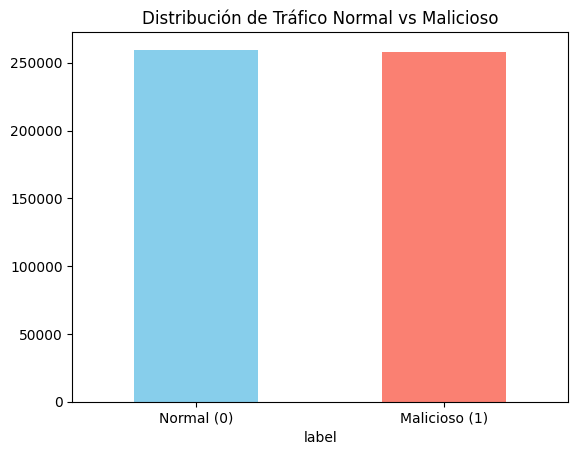

In [ ]:
import matplotlib.pyplot as plt

train_dataset['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribución de Tráfico Normal vs Malicioso')
plt.xticks([0, 1], ['Normal (0)', 'Malicioso (1)'], rotation=0)
plt.show()

In [ ]:
# Normalización
scaler = StandardScaler()
X_train = train_dataset.drop('label', axis=1)
y_train = train_dataset['label']
X_test = test_dataset.drop('label', axis=1)
y_test = test_dataset['label']

In [ ]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Confirmar dimensiones
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

Tamaño del conjunto de entrenamiento: (517352, 341)
Tamaño del conjunto de prueba: (196472, 341)


In [ ]:
train_dataset.head(10)  # Observar 10 primeras filas del dataset

,src_port,dst_port,duration,packets_count,fwd_packets_count,bwd_packets_count,total_payload_bytes,fwd_total_payload_bytes,bwd_total_payload_bytes,payload_bytes_max,...,min_fwd_payload_bytes_delta_len,max_fwd_payload_bytes_delta_len,mean_fwd_payload_bytes_delta_len,mode_fwd_payload_bytes_delta_len,variance_fwd_payload_bytes_delta_len,std_fwd_payload_bytes_delta_len,median_fwd_payload_bytes_delta_len,skewness_fwd_payload_bytes_delta_len,cov_fwd_payload_bytes_delta_len,label
228766,51268,80,191.613189,56,36,20,2831,2349,482,482,...,-275.0,168.0,0.00,0.0,5159.6000,71.8304,0.0,-1.0598,6.180156,1
9261,46852,80,0.000000,1,1,0,0,0,0,0,...,0.0,0.0,0.00,0.0,0.0000,0.0000,0.0,0.0000,0.000000,1
435124,43536,80,0.000000,1,1,0,0,0,0,0,...,0.0,0.0,0.00,0.0,0.0000,0.0000,0.0,0.0000,0.000000,0
366020,60084,80,0.926624,322,187,135,861106,7777,853329,11228,...,-101.0,101.0,0.00,-101.0,8336.3011,91.3033,0.0,0.0000,0.329401,0
141315,37066,80,1.720296,11,6,5,11551,359,11192,7240,...,-359.0,359.0,0.00,0.0,51552.4000,227.0515,0.0,0.0000,6.180156,1
158601,44700,80,4.056547,19,12,7,12664,1472,11192,2896,...,-368.0,368.0,0.00,0.0,24622.5455,156.9157,0.0,0.0000,6.180156,1
448181,80,52558,0.000020,2,1,1,2896,2896,0,2896,...,0.0,0.0,0.00,0.0,0.0000,0.0000,0.0,0.0000,0.000000,0
213216,54026,80,0.000093,9,5,4,189,189,0,135,...,-102.0,114.0,8.25,-102.0,5892.1875,76.7606,10.5,-0.0862,9.304300,1
301363,80,41210,0.000017,2,1,1,2896,2896,0,2896,...,0.0,0.0,0.00,0.0,0.0000,0.0000,0.0,0.0000,0.000000,0
290772,80,57530,0.000000,1,0,1,0,0,0,0,...,0.0,0.0,0.00,0.0,0.0000,0.0000,0.0,0.0000,0.000000,0


In [ ]:
test_dataset.head(10)  # Observar 10 primeras filas del dataset

,src_port,dst_port,duration,packets_count,fwd_packets_count,bwd_packets_count,total_payload_bytes,fwd_total_payload_bytes,bwd_total_payload_bytes,payload_bytes_max,...,min_fwd_payload_bytes_delta_len,max_fwd_payload_bytes_delta_len,mean_fwd_payload_bytes_delta_len,mode_fwd_payload_bytes_delta_len,variance_fwd_payload_bytes_delta_len,std_fwd_payload_bytes_delta_len,median_fwd_payload_bytes_delta_len,skewness_fwd_payload_bytes_delta_len,cov_fwd_payload_bytes_delta_len,label
177372,55774,80,1.953040,24,11,13,22760,303,22457,2896,...,-101.0,101.0,0.0,0.0,6120.6000,78.2343,0.0,0.0000,0.070821,0
72453,46544,80,8.328251,16,9,7,11517,325,11192,2896,...,-325.0,325.0,0.0,0.0,26406.2500,162.5000,0.0,0.0000,7.152572,1
58281,44706,80,0.313267,11,6,5,11564,372,11192,7240,...,-372.0,372.0,0.0,0.0,55353.6000,235.2735,0.0,0.0000,7.152572,1
55709,47646,80,0.749183,12,7,5,11536,344,11192,7240,...,-344.0,344.0,0.0,0.0,39445.3333,198.6085,0.0,0.0000,7.152572,1
79416,33252,80,0.034228,9,5,4,3617,140,3477,3477,...,-140.0,140.0,0.0,0.0,9800.0000,98.9949,0.0,0.0000,0.070821,0
151160,80,41564,0.000018,2,1,1,2896,2896,0,2896,...,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0000,0.000000,0
108055,58702,80,0.691190,17,9,8,11431,202,11229,2896,...,-101.0,101.0,0.0,0.0,5100.5000,71.4178,0.0,0.0000,0.070821,0
34476,59256,80,1.484505,12,7,5,11510,318,11192,7240,...,-318.0,318.0,0.0,0.0,33708.0000,183.5974,0.0,0.0000,7.152572,1
12047,49334,80,262.675951,25,17,8,489,324,165,250,...,-231.0,250.0,0.0,0.0,7282.5000,85.3376,0.0,0.3304,7.152572,1
127869,80,56138,0.000017,2,0,2,2896,0,2896,2896,...,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0000,0.000000,0


#***3. Entrenamiento del modelo***

In [ ]:
# Entrenamiento del modelo
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

#***4. Evaluación***

              precision    recall  f1-score   support

           0       1.00      0.85      0.92    122867
           1       0.80      1.00      0.89     73605

    accuracy                           0.90    196472
   macro avg       0.90      0.92      0.90    196472
weighted avg       0.92      0.90      0.91    196472



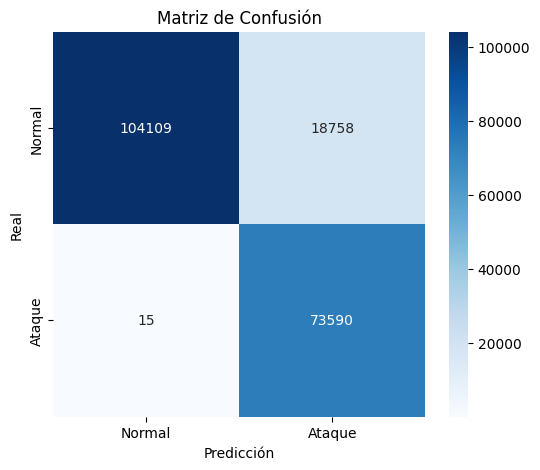

In [ ]:
import seaborn as sns

# Evaluación
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Ataque'], yticklabels=['Normal', 'Ataque'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()